# Post-processing retrieve.py

In [1]:
import pandas as pd
import collections
import pub
import matplotlib.pyplot as plt
import numpy as np
pub.SetPlotRC_CompGeosci()

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999; # or cell->current cell->Toggle

<IPython.core.display.Javascript object>

In [3]:
#df = pd.read_csv("png/session_noStirling_noProb.oldmrvbf/stats.csv") # done 601. Looking excellent. Total aggregate took 28h


In [4]:
#session="session_c0_f42_t1"
#session="session_c0_f42_t1_sizeplus"
#session="session_c1_f10_t1"
#session="session_c1_f42_t1"
#session="session_c1_f42_t2"


In [5]:
sessions = [
"session_c0_f10_t1",
"session_c0_f42_t1",
"session_c1_f42_t1",
#"session_c1_f42_t2"
#"session_c0_f42_t1_sizeplus"           
           ]


In [6]:
#sessions = ['session_c0_f42_t1', 'session_c1_f42_t1']
#session = sessions[0]

In [7]:
df = pd.read_csv("png/session_c0_f42_t1/stats.csv")


In [8]:
#df = df[df["size"] <= 601]
np.fromstring(df.CM[0][1:-1], sep=" ", dtype=int).reshape(8,8).sum()

19775

In [9]:
pub.symbols

'.+x*s<>^v12348phHDd'

In [10]:
# coordinates, from gdalinfo mrvbf.tif
x0=125.6245833
x1=117.2895833

y1=-35.1345833
y0=-26.8995833

# width of region
ym = 0.5 *(y0+y1) # average latitude 
m_per_deg_lon = np.cos(ym/57.29)*6371e3*2*np.pi / 360.  # at average lat
width_m = m_per_deg_lon * (x0-x1)
print (" width %1.0f km" % (width_m / 1e3))

# height of region
m_per_deg_lat = 6371e3*2*np.pi / 360.
height_m = m_per_deg_lat * (y0-y1)
print ("height %1.0f km" % (height_m / 1e3))

width_px = 10002
height_px = 9882
deg_per_px = 0.0008333333334 # 3 arc sec per px

# px size in km
width_m_per_px = width_m / width_px
height_m_per_px = height_m / height_px
print ("size m_per_px %1.0f x %1.0f" % (width_m_per_px, height_m_per_px))

f"""The region extends from {x1,y0} to {x0,y1}, covering {width_m/1e3} x {height_m/1e3} km 
  ({width_px} x {height_px} px)"""

 width 794 km
height 916 km
size m_per_px 79 x 93


'The region extends from (117.2895833, -26.8995833) to (125.6245833, -35.1345833), covering 794.2625379518848 x 915.6902209179415 km \n  (10002 x 9882 px)'

In [11]:
km_per_px = 10.41/121
def tx(px):
    """transform to km per px"""
    return px * km_per_px
    #return px

In [12]:
SIZES = np.array([50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 800, 1000])+1
for px in SIZES:
    print ("%5i  %4.1f" % (px, tx(px)))

   51   4.4
  101   8.7
  151  13.0
  201  17.3
  251  21.6
  301  25.9
  351  30.2
  401  34.5
  451  38.8
  501  43.1
  551  47.4
  601  51.7
  801  68.9
 1001  86.1


In [13]:
## accuracy vs size
clf_names = ["RF100", "lSV", "SV"] #disable "DT" "RF1000"]

map_clf_name_to_label_sym_col = {"lSV": ("SVC-LIN", '+', 'b'),
                                 "SV": ("SVC-RBF", 's', 'r'),
                                 "DT": ("DT", '>', 'g'),
                                 "RF100": ("RF-100", '<', 'k'),
                                 "lSVc1e1": ("SVC-LIN1", '+', 'c'),
                                 "lSVc1e2": ("SVC-LIN2", 's', 'g'),
                                 "lSVc1e3": ("SVC-LIN", '>', 'b'),
                                }
                          #"RF1000": "RF1k"}


_map_clf_name_to_label = {"lSV": "SVC-LIN",
                          "SV": "SVC-RBF",
                          "DT": "DT",
                          "RF100": "RF-100"}
                          #"RF1000": "RF1k"}
    
_map_clf_name_to_symbol = {"lSV": '+',
                          "SV": 's',
                          "DT": '>',
                          "RF100": '<'
                         }  


In [14]:
accuracy = "accuracy_mean" # old, based on cross-validation
#accuracy = "accuracy_diag_mean"
#accuracy = "accuracy_entire_diag_mean"


In [15]:
def ltx(the_string):
    """make string latex digestible"""
    return "\ensuremath{\mathrm{%s}}" % the_string.replace("_", "\_")

#df = pd.read_csv("png/session_noStirling_noProb_circ/stats.csv") #with proper mrvbf from Tania
#df = pd.read_csv("png/session_noStirling_noProb/stats.csv")
def post(session):
    print ("session", session)
    df = pd.read_csv("png/%s/stats.csv" % session)
    try:
        dfa = pd.read_csv("png/%s/stats_agg.csv" % session)
    except IOError:
        dfa = df
    
    
    # limit to size <= 601
    df = df[df["size"] <= 601]
    
    # transform
    df["size_km"] = tx(df["size"])
    df["step_km"] = tx(df["step"])
    dfa["size_km"] = tx(dfa["size"])
    dfa["step_km"] = tx(dfa["step"])

    #df = df.drop(u'Unnamed: 0', axis=1)
    #df = df[df.n_features > 10]
    #df.t_train /= 3600.
    #df.t_predict_map /= 3600.

    dfa.t_aggregate_map /= 3600.

    #dfa.head()
    print ("total aggregate time so far", dfa.t_aggregate_map.sum())

    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    #ax0, ax2, ax1, ax3 = axes.flatten()
    ax0, ax1 = axes.flatten(); ax2 = None
    ax0.set_title(r"$%s$" % ltx(session))
    ax1a = ax1.twiny()
    #ax0 = plt.subplot
    for i, the_name in enumerate(clf_names):
    #the_name = "DT"
        col = pub.gp_palette[i]
        label = ltx(map_clf_name_to_label[the_name])
        symbol = map_clf_name_to_symbol[the_name]
        i -= 2 # centre around actual step

        # -- accuracy vs size for step 25
        filtered_df = df[np.logical_and(df.clf_name==the_name, df['step']==25)]
        the_size = filtered_df['size_km']
        ax0.plot(the_size + 0*i, filtered_df[accuracy], symbol+'-', color=col, label=label)
        continue
        ## larger step sizes reduce observations and consistently result in lower accuracy
        if 0:
            # -- repeat for step 50
            filtered_df = df[np.logical_and(df.clf_name==the_name, df['step']==50)]
            the_size = filtered_df['size_km']
            ax0.plot(the_size + 0*i, filtered_df[accuracy], symbol+'--', color=col, label=label)

            # -- and 100
            if 0:
                filtered_df = df[np.logical_and(df.clf_name==the_name, df['step_km']==100)]
                the_size = filtered_df['size_km']
                ax0.plot(the_size + 0*i, filtered_df[accuracy], symbol+'-', color=col, label=label)

        # -- training time vs size, plotted on alt axis
        ax1a.plot(the_size, filtered_df.t_train, '.', color=col, label=label)
        ax1a.plot(the_size, filtered_df.t_predict_map, 'x', color=col, label="")
        ax1a.legend(loc="upper center", frameon=False)

        # -- accuracy vs step
        if ax2:
            filter2 = filtered_df[filtered_df['size'] > 400]
            the_step = filter2['step_km']
            ax2.plot(the_step + 3*i, filter2[accuracy], '.', color=col, label=label)

            # -- aggregate time vs step
            ax3.plot(the_step + 3*i, filter2.t_aggregate_map, '.', color=col, label=label)

    # -- aggregate time vs size
    ax1.plot(dfa['size_km'], dfa.t_aggregate_map, '-', color='k', label="agg")
    # -- repeat for step 50
    #filtered_df_50 = df[np.logical_and(df.clf_name=="lSV", df['step']==50)]
    #the_size = filtered_df_50['size']
    #ax1.plot(the_size, filtered_df_50.t_aggregate_map, '.', color=col, label="step50")
    ax1a.plot(dfa['size'], dfa.t_aggregate_map, '--', color='y', label="agg")

    
    
    print (i)
    ax1.set_ylabel(r"$\mathrm{t}_{\mathrm{aggregate}} [h]$")
    ax1.set_xlabel(r"$\mathrm{size\,[km]}$")
    #ax1.legend(loc="best", frameon=False)

    ax0.set_ylabel("accuracy")
    ax0.set_ylim(0.5,1.0)
    #ax0.set_xlim(0, 90) # km
    ax0.legend(loc="best", frameon=False)

    if ax2:
        ax2.set_xlim(0,410)
        ax2.set_ylim(0.5,1.0)

        ax3.set_xlabel("step")
    plt.tight_layout()

    #filtered_df
    plt.savefig("png/%s/%s_stats.eps" % (session, session))

session session_c0_f42_t1_Cvar
total aggregate time so far 105.05987385504775
0      0.573841
1      0.760633
2      1.137540
3      1.654684
4      2.326065
5      3.385927
6      4.453176
7      8.383534
8      6.658961
9      9.031271
10    11.400925
11    11.422410
12    19.134707
13    24.736201
Name: t_aggregate_map, dtype: float64
0      4.387686
1      8.689339
2     12.990992
3     17.292645
4     21.594298
5     25.895950
6     30.197603
7     34.499256
8     38.800909
9     43.102562
10    47.404215
11    51.705868
12    68.912479
13    86.119091
Name: size_km, dtype: float64
Done


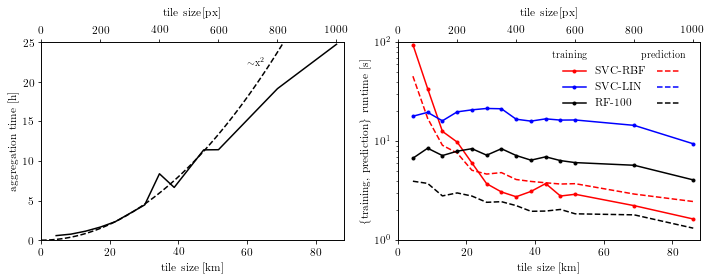

In [19]:
from matplotlib.patches import Rectangle

def post_aggregate(session):
    print ("session", session)
    df = pd.read_csv("png/%s/stats.csv" % session)
    try:
        dfa = pd.read_csv("png/%s/stats_agg.csv" % session)
    except IOError:
        dfa = df
    
    
    # limit to size <= 601
    #df = df[df["size"] <= 601]
    
    # transform
    df["size_km"] = tx(df["size"])
    df["step_km"] = tx(df["step"])
    dfa["size_km"] = tx(dfa["size"])
    dfa["step_km"] = tx(dfa["step"])

    #df = df.drop(u'Unnamed: 0', axis=1)
    #df = df[df.n_features > 10]
    #df.t_train /= 3600.
    #df.t_predict_map /= 3600.

    dfa.t_aggregate_map /= 3600.

    #dfa.head()
    print ("total aggregate time so far", dfa.t_aggregate_map.sum())

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex="col", figsize=(10., 4))
    #ax1.set_title(r"$%s$" % ltx(session))
    #ax1a = ax1.twinx()
    
    # -- LHS aggregate time
    ax1.plot(dfa['size_km'], dfa.t_aggregate_map, '-', color='k', label="agg")
    
    print (dfa.t_aggregate_map)
    print (dfa['size_km'])
    

    X = np.linspace(0, 100, 101)
    ax1.plot(X, 0.005*X**2, 'k--')
    #ax1.text(57, 22, r'$\propto{x^2}$')
    ax1.text(60, 22, r'$\sim$\textrm{x\textsuperscript{2}}')
    
    #print (dfa['size_km'], dfa.t_aggregate_map)
    # -- repeat for step 50
    #filtered_df_50 = df[np.logical_and(df.clf_name=="lSV", df['step']==50)]
    #the_size = filtered_df_50['size']
    #ax1.plot(the_size, filtered_df_50.t_aggregate_map, '.', color=col, label="step50")
    
    # alt axis: tile size in px
    if 1:
        ax1a = ax1.twiny()
        #ax1a.plot(dfa['size'], dfa.t_aggregate_map, '--', color='y', label="agg")
        ax1a.set_xlabel(r"\textrm{tile size\,[px]}", labelpad=10)
    x1 = 1025
    ax1.set_xlim(0, tx(x1))
    ax1a.set_xlim(0, x1)
    ax1.set_ylim(0, 25)
    
    #ax1.set_ylabel(r"$\mathrm{t}_{\mathrm{aggregate}} [h]$")
    #ax1.set_ylabel(r"t\textsubscript{aggregate} [h]")
    ax1.set_ylabel(r"\textrm{aggregation time [h]}")
    ax1.set_xlabel(r"\textrm{tile size [km]}")

    # -- RHS training and prediction time
    handles_1 = []
    handles_2 = []
    labels = []

    _clf_names = ["SV", "lSVc1e3", "RF100"]

    for i, the_name in enumerate(_clf_names):
    #the_name = "DT"
        #col = 'krb'[i]
        label, sym, col = map_clf_name_to_label_sym_col[the_name]
    ##label = ltx(label) 
        label = r"\textrm{%s}" % label
        #label = ltx(map_clf_name_to_label[the_name])
        #symbol = map_clf_name_to_symbol[the_name]
        i -= 2 # centre around actual step

        # -- accuracy vs size for step 25
        filtered_df = df[(df.clf_name==the_name) & (df['step']==25)]
        the_size = filtered_df['size_km']
        the_size_px = filtered_df['size']
        #print (the_size_px)

        # -- training time vs size, plotted on alt axis
        line, = ax2.plot(the_size, filtered_df.t_train, '.-', color=col, label=label)
        handles_1.append(line)
        labels.append(label)

        line, = ax2.plot(the_size, filtered_df.t_predict_map, '--', color=col,
                         label=" ")
        handles_2.append(line)
        
        #print ("\n\n", the_name, ">>>>>\n", filtered_df.t_train,
        #       "\n\n", filtered_df.t_predict_map)
    
        
    # two-col legend
    leg = ax2.legend(handles_1 + handles_2, labels + [".", ".", "."], 
                     ncol=2, columnspacing=1,
                     #loc="upper center", 
                     loc=(0.53, 0.64), frameon=False)
    for text in leg.texts[3:]:
        text.set_visible(False)
    leg.set_zorder(10)
    ax2_y1 = 100
    ax2.text(45, ax2_y1*0.7, r'\textrm{training}')
    ax2.text(71, ax2_y1*0.7, r'\textrm{prediction}')
    
    # draw rectangle on top of legend to cover up non-empty labels
    #rectangle = Rectangle((83, 92), 5, 35, fc='w', zorder=20)
    #ax2.add_patch(rectangle)

    # alt axis: tile size in px
    if 1:
        ax2a = ax2.twiny()
        ax2a.set_xlabel(r"\textrm{tile size\,[px]}", labelpad=10)

    ax2.set_ylabel(r"\textrm{\{training, prediction\} runtime [s]}")    
    y0 = 1
    ax2.set_xlim(0, tx(x1))
    ax2a.set_xlim(0, x1)
    ax2.set_ylim(y0, ax2_y1)
    #ax2.set_ylim(0, 30)
    ax2.set_xlabel(r"\textrm{tile size [km]}")
    ax2.semilogy()

    plt.tight_layout()
    plt.savefig("png/%s/%s_stats.eps" % (session, session))
    print ("Done")
    
#for the_session in sessions:
#    post_aggregate(the_session)

post_aggregate("session_c0_f42_t1_Cvar")    

In [17]:
leg.texts


NameError: name 'leg' is not defined

In [ ]:
np.polyfit?

In [ ]:
from matplotlib.patches import Rectangle

def post_mem_usage(session):
    print ("session", session)
    df = pd.read_csv("png/%s/stats.csv" % session)
    try:
        dfa = pd.read_csv("png/%s/stats_agg.csv" % session)
    except IOError:
        dfa = df
    
    
    # limit to size <= 601
    #df = df[df["size"] <= 601]
    
    # transform
    df["size_km"] = tx(df["size"])
    df["step_km"] = tx(df["step"])
    dfa["size_km"] = tx(dfa["size"])
    dfa["step_km"] = tx(dfa["step"])

    #df = df.drop(u'Unnamed: 0', axis=1)
    #df = df[df.n_features > 10]
    #df.t_train /= 3600.
    #df.t_predict_map /= 3600.

    fig, ax2 = plt.subplots(1, 1, sharex="col", figsize=(5, 4))
    #ax1.set_title(r"$%s$" % ltx(session))
    #ax1a = ax1.twinx()

    # -- RHS training and prediction time
    handles_1 = []
    handles_2 = []
    labels = []
    
    for i, the_name in enumerate(clf_names):
    #the_name = "DT"
        col = 'krb'[i]
        label = ltx(map_clf_name_to_label[the_name])
        symbol = map_clf_name_to_symbol[the_name]
        i -= 2 # centre around actual step

        # -- accuracy vs size for step 25
        filtered_df = df[(df.clf_name==the_name) & (df['step']==25)]
        the_size = filtered_df['size_km']
        the_size_px = filtered_df['size']
        #print (the_size_px)

        # -- training time vs size, plotted on alt axis
        line, = ax2.plot(the_size, filtered_df.mem_after_agg_MB, '.-', color=col, label=label)
        handles_1.append(line)
        labels.append(label)

        line, = ax2.plot(the_size, filtered_df.mem_after_predict_MB, '--', color=col, label=" ")
        handles_2.append(line)
        
    # two-col legend
    leg = ax2.legend(handles_1 + handles_2, labels + [".", ".", "."], 
                     ncol=2, columnspacing=1,
                     #loc="upper center", 
                     loc=(0.53, 0.64), frameon=False)
    leg.set_zorder(10)
    ax2.text(46, 129, 'training')
    ax2.text(72, 129, 'prediction')
    
    # draw rectangle on top of legend to cover up non-empty labels
    rectangle = Rectangle((83, 92), 5, 35, fc='w', zorder=20)
    ax2.add_patch(rectangle)

    # alt axis: tile size in px
    if 1:
        ax2a = ax2.twiny()
        ax2a.set_xlabel(r"tile size\,[px]")

    ax2.set_ylabel(r"mem usage [MB]")    
    x1 = 1025
    ax2.set_xlim(0, tx(x1))
    ax2a.set_xlim(0, x1)
    #ax2.set_ylim(0, 140)
    ax2.set_xlabel(r"tile size [km]")

    plt.tight_layout()
    plt.savefig("png/%s/%s_mem.pdf" % (session, session))

for the_session in sessions:
    post_mem_usage(the_session)
    

In [ ]:
df.mem_after_predict_MB

In [ ]:
for the_clf in clf_names:
    print (the_clf)
    print ("  train   %5.1f s" % df[df.clf_name==the_clf].t_train.mean())
    print ("  predict %5.1f s" % df[df.clf_name==the_clf].t_predict_map.mean())
    

In [ ]:

session = "session_quick"
print ("session", session)
#dfa = pd.read_csv("png/%s/stats_agg.csv" % session)
df = pd.read_csv("png/%s/stats.csv" % session)
df.head()


## production-ready

In [ ]:
accuracy = "accuracy_mean" # old, based on cross-validation
#accuracy = "accuracy_diag_mean"accuracy = "accuracy_entire_diag_mean"


session = "session_c0_f42_t1"
print ("session", session)
#dfa = pd.read_csv("png/%s/stats_agg.csv" % session)
df = pd.read_csv("png/%s/stats.csv" % session)

#df = df[df["size"] <= 601]

# transform
df["size"] = tx(df["size"])
df["step"] = tx(df["step"])


fig, ax0 = plt.subplots(1, 1, sharex="col", figsize=(5., 5))
#ax0 = axes.flatten()
#ax0 = plt.subplot
for i, the_name in enumerate(clf_names):
#the_name = "DT"
    #col = pub.gp_palette[i]
    #label = map_clf_name_to_label[the_name]
    label, sym, col = map_clf_name_to_label_sym_col[the_name]

    i -= 2 # centre around actual step

    # -- accuracy vs size for step 25
    filtered_df = df[np.logical_and(df.clf_name==the_name, df['step']==tx(25))]
    the_size = filtered_df['size']
    ax0.plot(the_size + 0*i, filtered_df[accuracy], '.-', color=col, 
             label=r"$\mathrm{%s}$" % label)

    ## larger step sizes reduce observations and consistently result in lower accuracy
    if 0:
        # -- repeat for step 50
        filtered_df = df[np.logical_and(df.clf_name==the_name, df['step']==tx(50))]
        the_size = filtered_df['size']
        ax0.plot(the_size + 0*i, filtered_df[accuracy], '.--', color=col, label=label)

        # -- and 100
        filtered_df = df[np.logical_and(df.clf_name==the_name, df['step']==tx(100))]
        the_size = filtered_df['size']
        ax0.plot(the_size + 0*i, filtered_df[accuracy], '-', color=col, label=label)

    
    # -- aggregate time vs size
    #ax1.plot(the_size, filtered_df["t_aggregate_map"], '.', color=col, label=label)

print (i)
#ax1.set_ylabel("t aggregate")
ax0.set_xlabel(r"$\mathrm{size\,[km]}$")

ax0.set_ylabel(ltx("accuracy"))
ax0.set_ylim(0., 1)
ax0.legend(loc="best", frameon=False)

#ax2.set_xlim(0,410)
#ax2.set_ylim(0.5,1)

#ax3.set_xlabel("step")
#plt.tight_layout()
plt.savefig("accuracy_vs_size_%s.eps" % session)
#filtered_df
# - proper plot size
# - font size
# - font

In [ ]:
print ("session", session)
dfa = pd.read_csv("png/%s/stats_agg.csv" % session)
df = pd.read_csv("png/%s/stats.csv" % session)
# transform
df["size"] = tx(df["size"])
df["step"] = tx(df["step"])

df.head()

## stride


In [20]:

df = pd.read_csv("png/%s/stats.csv" % session)
df["size"] = tx(df["size"])
df["step"] = tx(df["step"])


fig, ax0 = plt.subplots(1, 1, sharex="col", figsize=(5., 5))
#ax0 = axes.flatten()
#ax0 = plt.subplot
for i, the_name in enumerate(clf_names):
#the_name = "DT"
    col = pub.gp_palette[i]
    label = map_clf_name_to_label[the_name]

    i -= 2 # centre around actual step

    # -- accuracy vs size for step 25
    filtered_df = df[np.logical_and(df.clf_name==the_name, True)]
    the_stride = filtered_df['step']

    ## larger step sizes reduce observations and consistently result in lower accuracy
    # -- repeat for step 50
    ax0.plot(the_stride + 0*i, filtered_df[accuracy], '.--', color=col, label=label)

ax0.set_xlabel(r"$\mathrm{size\,[km]}$")
ax0.set_ylabel(ltx("accuracy"))
ax0.set_ylim(0.5, 1)
plt.savefig("accuracy_vs_stride.eps")

NameError: name 'map_clf_name_to_label' is not defined

In [ ]:
mask = np.logical_and(df['size']==401, df['step']==50)
df[mask].head()

## t_aggregate vs step, size, n_feat

In [21]:
n_ops = (10000./df['step'])**2 * df["size"]**2
plt.plot(n_ops, df.t_aggregate_map / n_ops, '.')
plt.semilogy()
#plt.ylim(1e-8, 1e-7)
#print (df.t_aggregate_map / n_ops).tail()
t_per_op = 2.7e-7


In [22]:
%load_ext autoreload
%autoreload 2

import geopandas
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats.mstats
from pdb import pm
import numpy.testing as npt
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.cluster import KMeans
import string
from tictoc import Tic
from common import FeatureCallback, FeatureHistogram, Aggregator, \
                   path_to_landforms_shp, figsize, \
                   get_equal_freq_bins, interquatrile_range, BlockInfo, \
                   MapPlotter, map_class_ID_to_colour, \
                   load_src_and_band


/usr/lib/python3/dist-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


ImportError: cannot import name 'path_to_landforms_shp'

In [ ]:
clf = svm.SVC(C=2.33, gamma=1.67)

In [ ]:
clf.score?

## parse log file


Acc   [0.722 0.88  0.938 0.931 0.902 0.938 0.938 0.906 0.899 0.816 0.759 0.744
 0.71  0.619]
Acc   [0.936 0.978 0.974 0.97  0.963 0.942 0.918 0.895 0.891 0.895 0.847 0.878
 0.873 0.853]
Acc   [0.949 0.972 0.967 0.962 0.947 0.931 0.89  0.883 0.838 0.801 0.751 0.705
 0.708 0.616]
Sizes [ 4.388  8.689 12.991 17.293 21.594 25.896 30.198 34.499 38.801 43.103
 47.404 51.706 68.912 86.119]


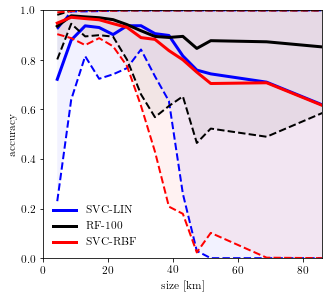

In [48]:
#df = pd.read_csv("png/session_c0_f42_t1/stats.csv")
#df = pd.read_csv("png/session_c1_f42_t1/stats.csv")
session = "session_c1_f42_t1" # best Acc 98.0 at 101
session = "session_c0_f42_t1" # best Acc 97.8 at 101
session = "session_c0_f42_t1_Cvar"
#session = "session_c0_f10_t1" # best Acc 89.4 at 201
clf_names = [#lSVc1e1", #"lSVc1e2", 
             "lSVc1e3", 
             "RF100", "SV"]
# #disable "DT" "RF1000", "lSV",]

df = pd.read_csv("png/%s/stats.csv" % session)
from common import map_class_ID_to_colour
fig, ax0 = plt.subplots(1, 1, sharex="col", figsize=(5., 4.558))
#for classID in range(8):
#    color = map_class_ID_to_colour(classID)

# get confusion matrix
#s = df.CM[0][1:-1]
#df.head()

# transform
df["size"] = tx(df["size"])
df["step"] = tx(df["step"])
np.set_printoptions(precision=3)
for i, the_name in enumerate(clf_names):
    #the_name = "RF100"
    #col = pub.gp_palette[i]
    #label = ltx(map_clf_name_to_label[the_name])
    #symbol = map_clf_name_to_symbol[the_name]
    label, symbol, col = map_clf_name_to_label_sym_col[the_name]
    label = r"\textrm{%s}" % label

    filtered_df = df[df.clf_name == the_name]
#for index, row in fdf.iterrows():
    diags = np.array([np.diag(np.fromstring(item[1:-1], sep=" ", dtype=float).reshape(8,8)) \
                      for item in filtered_df['CM_normed']])
    sizes = filtered_df['size'].values

    plt.plot(sizes, diags.mean(axis=1), col+'-', label=label, lw=3)
#    plt.plot(sizes, np.median(diags, axis=1), col+'-', label=the_name, lw=2, alpha=0.5)

    plt.fill_between(sizes, diags.max(axis=1), diags.min(axis=1), facecolor=col, alpha=0.05)
    plt.plot(sizes, diags.max(axis=1), col+'--', lw=2)
    plt.plot(sizes, diags.min(axis=1), col+'--', lw=2)
    print ("Acc  ", diags.mean(axis=1))

print ("Sizes", sizes)
#diags.mean(axis=1)
plt.legend(loc="best", frameon=False)

ax0.set_xlabel(r"\textrm{size [km]}")

ax0.set_ylabel(r"\textrm{accuracy}")
#ax0.set_ylim(0.5, 1)
ax0.legend(loc="lower left", frameon=False)

ax0.set_xlim(0, 86)
ax0.set_ylim(0.,1.0)

#ax3.set_xlabel("step")
#plt.tight_layout()
plt.savefig("accuracy_vs_size_%s.pdf" % session)#, dpi=200)
#filtered_df


In [49]:
ddf = df.drop(['CM', 't_aggregate_map','is_unsupervised', 'mem_after_agg_MB'], axis=1)
ddf[ddf.clf_name=="RF100"]


n_features       size      step  small_size  avg_block_km clf_name  \
4           42   4.387686  2.150826          25      4.387914    RF100   
9           42   8.689339  2.150826          25      8.689791    RF100   
14          42  12.990992  2.150826          25     12.991668    RF100   
19          42  17.292645  2.150826          25     17.293545    RF100   
24          42  21.594298  2.150826          25     21.595421    RF100   
29          42  25.895950  2.150826          25     25.897298    RF100   
34          42  30.197603  2.150826          25     30.199175    RF100   
39          42  34.499256  2.150826          25     34.501052    RF100   
44          42  38.800909  2.150826          25     38.802929    RF100   
49          42  43.102562  2.150826          25     43.104805    RF100   
54          42  47.404215  2.150826          25     47.406682    RF100   
59          42  51.705868  2.150826          25     51.708559    RF100   
64          42  68.912479  2.150826          25     68.916066    RF100   
69          42  86.119091  2.150826          25     86.123573    RF100   

    accuracy_mean  accuracy_std   t_train  accuracy_diag_mean  \
4        0.797204      0.064570  6.725019                 1.0   
9        0.879197      0.076610  8.486743                 1.0   
14       0.920699      0.073952  7.155830                 1.0   
19       0.946266      0.059675  7.916144                 1.0   
24       0.954919      0.053359  8.396501                 1.0   
29       0.969026      0.040034  7.218565                 1.0   
34       0.968290      0.038910  8.386788                 1.0   
39       0.974310      0.033856  7.163965                 1.0   
44       0.979604      0.025841  6.429119                 1.0   
49       0.987685      0.016238  6.948050                 1.0   
54       0.991347      0.010878  6.364246                 1.0   
59       0.994119      0.007427  6.074198                 1.0   
64       0.999430      0.000872  5.709142                 1.0   
69       1.000000      0.000000  4.061675                 1.0   

    accuracy_diag_std  t_predict_map  accuracy_entire_diag_mean  \
4                 0.0       3.939601                   0.935887   
9                 0.0       3.744489                   0.978014   
14                0.0       2.798901                   0.973916   
19                0.0       2.999944                   0.970337   
24                0.0       2.789416                   0.962574   
29                0.0       2.411852                   0.942556   
34                0.0       2.447175                   0.917973   
39                0.0       2.233377                   0.894707   
44                0.0       1.956773                   0.890840   
49                0.0       1.967612                   0.895254   
54                0.0       2.042971                   0.846473   
59                0.0       1.845781                   0.877784   
64                0.0       1.801340                   0.873253   
69                0.0       1.322139                   0.852613   

    accuracy_entire_diag_std  \
4                   0.056763   
9                   0.020823   
14                  0.032701   
19                  0.032001   
24                  0.036166   
29                  0.069070   
34                  0.117255   
39                  0.151536   
44                  0.140821   
49                  0.125259   
54                  0.199746   
59                  0.155983   
64                  0.160682   
69                  0.157390   

                                            CM_normed  mem_after_predict_MB  
4   [0.96  0.001 0.01  0.025 0.    0.    0.    0.0...           1987.148438  
9   [0.999 0.    0.001 0.    0.    0.    0.    0. ...           2180.203125  
14  [1.    0.    0.    0.    0.    0.    0.    0. ...           2204.867188  
19  [1.    0.    0.    0.    0.    0.    0.    0. ...           2204.742188  
24  [1.    0.    0.    0.    0.    0.   

In [25]:
df = pd.read_csv("png/session_c0_f42_t1/stats.csv")
#df = pd.read_csv("png/session_c1_f42_t1/stats.csv")

# transform
df["size"] = tx(df["size"])
df["step"] = tx(df["step"])


means_c0 = np.zeros((0))
for i, the_name in enumerate(clf_names):

    fdf = df[df.clf_name == the_name]
    #for index, row in fdf.iterrows():
    diags = np.array([np.diag(np.fromstring(item[1:-1], sep=" ", dtype=float).reshape(8,8)) for item in fdf['CM_normed']])
    diags_int = np.array([np.diag(np.fromstring(item[1:-1], sep=" ", dtype=float).reshape(8,8)) for item in fdf['CM']])
    #print np.median(diags, axis=1)
    print (np.mean(diags, axis=1))
    means_c0 = np.hstack((means_c0, np.mean(diags, axis=1)[0:12]))
    print (means_c0.shape)
        #print sizes
if 0:
    from common import map_class_ID_to_colour
    for classID in range(8):
        color = map_class_ID_to_colour(classID)
        plt.plot(sizes, diags[:,classID], color=color, label="%i" % (classID+1))
        #plt.plot(sizes, mins[:,classID])
    plt.legend(loc="best", frameon=False)

IndexError: tuple index out of range

In [26]:
plt.plot(means_c1 / means_c0)


NameError: name 'means_c1' is not defined

In [27]:
np.array([(np.fromstring(item[1:-1], sep=" ", dtype=int).reshape(8,8)) for item in fdf['CM']]).sum(axis=2)



AxisError: axis 2 is out of bounds for array of dimension 1

In [28]:
sizes.shape

(14,)

In [29]:
print diags.min(axis=1)
print diags.max(axis=1)

SyntaxError: invalid syntax (<ipython-input-29-231ada766ab3>, line 1)

In [30]:
np.median(diags,axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [31]:
np.median


<function numpy.lib.function_base.median(a, axis=None, out=None, overwrite_input=False, keepdims=False)>

In [32]:
s = """[ 754    2    1   54    0    0   20    0]
 [   6  373    6    2    0    0  196    3]
 [  29    9 3117  139    5    6   45  317]
 [  41    0  168 1569   72    0  143   44]
 [   2    1    9   20  659    0  154   26]
 [   0    0   22    1    0 1744    0  103]
 [   1   21    2    7    1    0  530    1]
 [  19    0  432   61   74  455  128 8771]"""
#, sep=" ")



In [33]:
a = np.fromstring(s.replace('[','').replace(']','').replace('\n', ''), sep=" ", dtype=int).reshape(8,8)


In [34]:
a.sum()

20365

In [29]:
s = """[[  827     0     0     0     0     0     0     0]
 [    0   579     0     0     0     0     0     0]
 [    0     0  4520     0     0     0     0     0]
 [    0     0     0  2730     0     0     0     0]
 [    0     0     0     0  1257     0     0     0]
 [    0     0     0     0     0  1910     0     0]
 [    0     0     0     0     0     0   525     0]
 [    0     0     0     0     0     0     0 10235]]"""
a = np.fromstring(s.replace('[','').replace(']','').replace('\n', ''), sep=" ", dtype=int).reshape(8,8)
print a.sum()


SyntaxError: invalid syntax (<ipython-input-29-a172b326d233>, line 10)

In [30]:
s = """[[  827     0     0     0     0     0     0     0]
 [    0   579     0     0     0     0     0     0]
 [    0     0  4520     0     0     0     0     0]
 [    0     0     0  2730     0     0     0     0]
 [    0     0     0     0  1257     0     0     0]
 [    0     0     0     0     0  1910     0     0]
 [    0     0     0     0     0     0   525     0]
 [    0     0     0     0     0     0     0 10235]]"""
a = np.fromstring(s.replace('[','').replace(']','').replace('\n', ''), sep=" ", dtype=int).reshape(8,8)
print a.sum()


SyntaxError: invalid syntax (<ipython-input-30-a172b326d233>, line 10)

### Gridsearch

In [ ]:
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV
iris = datasets.load_iris()
parameters = {'C':[1, 10]}
svc = svm.SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv=5)
clf.fit(iris.data, iris.target)

In [40]:
from __future__ import print_function

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

print(__doc__)

# Loading the Digits dataset
digits = datasets.load_digits()

# To apply an classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
X = digits.images.reshape((n_samples, -1))
y = digits.target

# Split the dataset in two equal parts
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=0)

# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(), tuned_parameters, cv=5,
                       scoring='%s_macro' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

# Note the problem is too easy: the hyperparameter plateau is too flat and the
# output model is the same for precision and recall with ties in quality.

Automatically created module for IPython interactive environment
# Tuning hyper-parameters for precision

Best parameters set found on development set:

{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.986 (+/-0.016) for {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
0.959 (+/-0.029) for {'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.026) for {'C': 10, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 100, 'gamma': 0.0001, 'kernel': 'rbf'}
0.988 (+/-0.017) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
0.982 (+/-0.025) for {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
0.975 (+/-0.014) for {'C': 1, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 10, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 100, 'kernel': 'linear'}
0.975 (+/-0.014) for {'C': 1000, 'kernel': 'linear'}

Detailed classification report:

The model 

Text(0,0.5,'C')

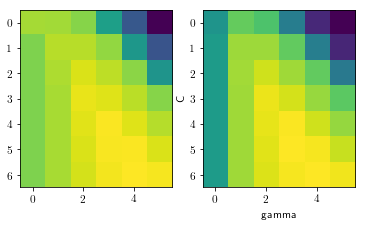

In [33]:
D = np.loadtxt("hyper.dat", delimiter=',')

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(D[:,0].reshape(7,6))
ax1.imshow(D[:,2].reshape(7,6))
plt.xlabel("gamma")
plt.ylabel("C")

In [25]:
Cs = D[::6,2]
gammas = D[:6,3]
print (Cs, gammas)

[1.e+00 1.e+01 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06] [1.e+00 1.e-01 1.e-02 1.e-03 1.e-04 1.e-05]


In [24]:
D = np.loadtxt("hyper3.dat", delimiter=',')

fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(D[:,0].reshape(7,6)) # precision
ax1.imshow(D[:,2].reshape(7,6)) # recall
plt.xlabel("gamma")
plt.ylabel("C")

Text(0,0.5,'C')

In [25]:
D.shape

(42, 6)

In [33]:
D[D[:,2].argmax()]
# best for prec: C=1e6, gamma=1e-4
# best for rec : same

array([9.04e-01, 6.00e-03, 9.00e-01, 5.00e-03, 1.00e+06, 1.00e-04])